# Pyradiomics features extraction

E. Lavrova  
24.04.2020

The simpliest example of radiomics features extraction for one image-mask pair with Pyradiomics package  
(you can modify it to process your data)  

The documentation you can find in here:  
https://pyradiomics.readthedocs.io/en/latest/   
More information in here:  
https://readthedocs.org/projects/pyradiomics/downloads/pdf/latest/  

Please, read carefully information about feature classes and features available for extraction; preprocessing and extraction parameters.   

You can find installation info on the web site as well. Or just install it running the cell below :)

In [38]:
! pip install pyradiomics

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Be sure you have numpy, matplotlib, SimpleITK installed as well. Nibabel is not needed for your project, as you would be working with Dicom files, but demonstration data is in Nifti format, so, you would need it as well. Csv package is needed, if you prefer to work with .csv files.  
(note: Dicom and Nifti are both medical imaging formats, Dicom is mode 'industrial' and it is used for all the modalities and in all the medical tasks, Nifti is more 'open source' and it is used in brain imaging only, but it's convenient, when you analyse the data)

In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import csv
import SimpleITK as sitk
from radiomics import featureextractor

C:\Users\e.lavrova\AppData\Local\Continuum\anaconda3\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


Loading imaging data: we have one subject, images are brain MRI, aquired with different MRI sequences (T1-weighted and FLAIR), so we can see the same brain, but different structures are highlighted differently. This particular data came from open source brain dataset http://lit.fe.uni-lj.si/tools.php?lang=eng. Also we have a brain mask - a binary mask, contouring brain on the image: 1-voxel is brain, 0-voxel is non-brain.

In [2]:
T1_name = 'patient01_T1W.nii.gz' # name of the file
T1_nii = nib.load(T1_name) # loading the file
T1 = T1_nii.get_fdata() # getting 3D array of voxels, representing the image, from Nifti structure

FLAIR_name = 'patient01_FLAIR.nii.gz'
FLAIR_nii = nib.load(FLAIR_name)
FLAIR = FLAIR_nii.get_fdata()

mask_name = 'patient01_brainmask.nii.gz'
mask_nii = nib.load(mask_name)
mask = mask_nii.get_fdata()

Checking sizes of voxels in mm (getting this info from Nifti metadata, stored inside the file), we need to be sure, that voxel sizes are the same for each image-mask pair

In [3]:
print ('T1w voxel size: ', T1_nii.header.get_zooms())
print ('FLAIR voxel size: ', FLAIR_nii.header.get_zooms())
print ('mask voxel size: ', mask_nii.header.get_zooms())

T1w voxel size:  (0.8, 0.46875, 0.46875)
FLAIR voxel size:  (0.8, 0.46875, 0.46875)
mask voxel size:  (0.8, 0.46875, 0.46875)


Checking sizes of images in each dimension, basically voxel numbers (getting this info from Nifti metadata, stored inside the file), we need to be sure, that they are the same as well for each image-mask pair

In [4]:
print ('T1w image size: ', T1.shape)
print ('FLAIR image size: ', FLAIR.shape)
print ('mask image size: ', mask.shape)

T1w image size:  (192, 512, 512)
FLAIR image size:  (192, 512, 512)
mask image size:  (192, 512, 512)


Looking at our images (just at central slice, as data is 3D data)

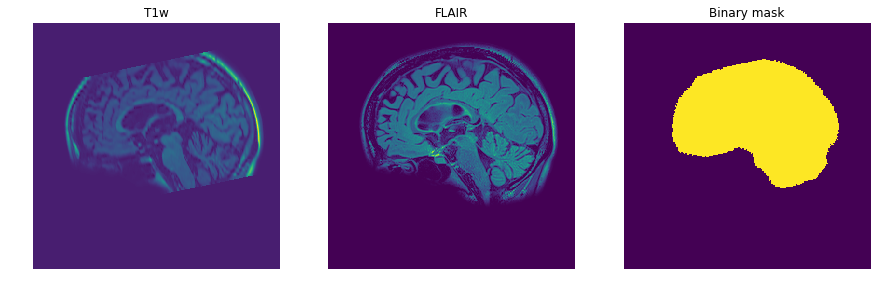

In [5]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.rot90(T1[int(T1.shape[0]/2), ...]))
plt.axis('off')
plt.title('T1w')

plt.subplot(1, 3, 2)
plt.imshow(np.rot90(FLAIR[int(FLAIR.shape[0]/2), ...]))
plt.axis('off')
plt.title('FLAIR')

plt.subplot(1, 3, 3)
plt.imshow(np.rot90(mask[int(mask.shape[0]/2), ...]))
plt.axis('off')
plt.title('Binary mask')

plt.show()

Features extraction function with some parameters, already defined by user. Important settings (which are changable): we are extracting features from original image (so no wavelets), all the feature classes available, didn't do intensity normalization, prefer intensity discretization with fixed bin count (you can read more about intensity discretization ant its impact in here https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0213459). Form of the output is changable, of course.

In [20]:
def extractFeatures(img_input, mask):
    
    # radiomics features extraction with pyradiomics package (https://www.radiomics.io)
    
    # input:
    # img_input - original image to be corrected (3D array)
    # mask - binary mask, representing ROI for correction (3D binary integer array with the same shape as img_input)
    
    # output:
    # f_v - feature vector (dictionary: f_v[feature] = value)

    i = sitk.GetImageFromArray(img_input)
    m = sitk.GetImageFromArray(mask)
    f_v = {}

    settings = {}
    #settings['preCrop'] = True
    settings['normalize'] = False

    settings['binCount'] = 50
    settings['resampledPixelSpacing'] = None
    settings['interpolator'] = sitk.sitkBSpline
    
    settings['sigma'] = [0.1, 0.5]

    extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

    extractor.addProvenance(False)
    extractor.disableAllFeatures()
    extractor.enableImageTypes(Original={}, LoG={})
    #extractor.enableImageTypes(LoG={})

    extractor.enableFeatureClassByName('firstorder', enabled=True)
    #extractor.enableFeatureClassByName('shape', enabled=True)
    extractor.enableFeatureClassByName('glcm', enabled=True)
    #extractor.enableFeatureClassByName('glrlm', enabled=True)
    #extractor.enableFeatureClassByName('glszm', enabled=True)
    #extractor.enableFeatureClassByName('gldm', enabled=True)
    #extractor.enableFeatureClassByName('ngtdm', enabled=True)

    extracted_ftrs = extractor.execute(i, m)

    for key, value in extracted_ftrs.items():
        f_v[key] = value

    print('features #: ' + str(len(f_v)))
    return f_v


def createHeader():
    
    # creates dataset header for extractFeatures extractor (to write result into Excel file)
    
    # input:
    # void
    
    # output:
    # list: ['sub', '{feature_0}', '{feature_1}', ..., '{feature_N}']
    
    f = {'sub': ''}
    i_t = np.ones((2, 2, 2))
    m_t = np.zeros((2, 2, 2))
    m_t[0, 0, 0] = 1
    m_t[1, 1, 1] = 1
    f.update(extractFeatures(i_t, m_t))

    return list(f.keys())

Extracting feature vectors from both MRI modalities (but it's the same subject, images are co-registered, so we are using the same mask)

In [21]:
features_vector_T1 = extractFeatures(T1, mask)
#features_vector_FLAIR = extractFeatures(FLAIR, mask)

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


features #: 126


How does feature vector look like

In [22]:
features_vector_T1

{'original_firstorder_10Percentile': array(65.),
 'original_firstorder_90Percentile': array(399.),
 'original_firstorder_Energy': array(5.66537446e+11),
 'original_firstorder_Entropy': array(5.00584375),
 'original_firstorder_InterquartileRange': array(182.),
 'original_firstorder_Kurtosis': array(2.13788919),
 'original_firstorder_Maximum': array(594.),
 'original_firstorder_MeanAbsoluteDeviation': array(99.37899691),
 'original_firstorder_Mean': array(251.24416572),
 'original_firstorder_Median': array(268.),
 'original_firstorder_Minimum': array(-84.),
 'original_firstorder_Range': array(678.),
 'original_firstorder_RobustMeanAbsoluteDeviation': array(75.57332787),
 'original_firstorder_RootMeanSquared': array(278.06006461),
 'original_firstorder_Skewness': array(-0.39393979),
 'original_firstorder_TotalEnergy': array(5.66537446e+11),
 'original_firstorder_Uniformity': array(0.03346255),
 'original_firstorder_Variance': array(14193.76872471),
 'original_glcm_Autocorrelation': array(

Probably, you would need to store you features, extracted from different subjects, in Excel/.csv file, because a table form is quite convenient for analysis. Anyway, it's ok, if you prefer any another format. Nevertheless, below you can find an example of how do I write the extracted features into .csv file. The only difference is that usually in each new row we have a new observation (in other words - new patient). In this demo case we'll have just two rows, showing feature vectors for two MRI modalities (but for one patient).

In [46]:
h = createHeader() # header for the table

csv_file = open('features.csv', 'w')
writer = csv.DictWriter(csv_file, fieldnames = h, lineterminator='\n') # header is already written to the file
writer.writeheader()

# writing T1w row - first row
f_mod = {'sub': 'T1w'} # indexing column, showing modality name
f_mod.update(features_vector_T1)
writer.writerow(f_mod)

# writing FLAIR row - second row
f_mod = {'sub': 'FLAIR'} # indexing column, showing modality name
f_mod.update(features_vector_FLAIR)
writer.writerow(f_mod)

csv_file.close() # close the file

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


features #: 107


Now we'll try to open our features .csv file. The most convenient package to work with datatable is pandas. 

In [48]:
import pandas as pd

features_dataframe = pd.read_csv('features.csv')

features_dataframe

,sub,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,...,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,T1w,0.696158,0.455607,146.699633,321.987491,269.072481,360.168016,360.61198,363.463891,7.324874e+06,...,0.181233,0.002982,0.085628,45.112426,0.000295,127.680740,0.000006,855.220467,0.050460,0.004872
1,FLAIR,0.696158,0.455607,146.699633,321.987491,269.072481,360.168016,360.61198,363.463891,7.324874e+06,...,5.422219,0.037948,0.103999,27.888255,0.002256,363.387973,0.000002,1550.595836,0.040004,0.003385


Now you can modify this script to go through patients' folders, extract radiomics features for each patient and 'put' the extracted feature vector into .csv file.

Now you have an idea of possible feature extraction implementation. Below is an example of feature extraction from multiple patients. Let's assume you have a dataset directory, inside you have patients' folders, for each patient, all the patient's files are in this folder:  
  
sub_folder:  
  - sub1:  
      - sub1_image_file.nii
      - sub1_roi_file.nii
  - sub2:
      - sub2_image_file.nii
      - sub2_roi_file.nii
  - ...
  - sub N:
      - subN_image_file.nii
      - subN_roi_file.nii

In [ ]:
import os

ds_folder = '...' # put here full path to dataset directory

# below are templates (string data type) for image and roi names in folders
# from subject to subject, they can change, but anyway, all image names have soething commom
# for example, if you'll look at data description I gave above, for these names templates would be:
# * is a changable part of name, it could be any symbol, or composition of symbols, or void value
# it's important that in subject's folder there is one and only file, fitting this template:
# if there would be multiple files, glob.glob function (see below) will select the first one (more likely, in relevance to
# alphabet order), if there are no any files fitting the teplate, glob.glob returns empty list and nothing is working :)

img_name_template = '*_image_file.nii'
roi_name_template = '*_roi_file.nii'

h = createHeader()
csv_file = open(ds_folder + '/features.csv', 'w') # or another name or another adress
writer = csv.DictWriter(csv_file, fieldnames = h, lineterminator='\n')
writer.writeheader()

# automatic run through all the folders in ds_folder is implemented
# so ds_folder should contain patients' folders only!
for item in os.listdir(ds_folder):
    if os.path.isdir(ds_folder+'/' +item):
    
        img_name = glob.glob(ds_folder + '/' + item + '/' + img_name_template)[0]
        img_nii = nib.load(img_name)
        img = img_nii.get_fdata()

        roi_name = glob.glob(ds_folder + sub + '/' + roi_name_template)[0]
        roi_nii = nib.load(roi_name)
        roi = roi_nii.get_fdata()

        roi = (roi_icv > 0.9).astype(int) # if your binary mask is not really binary mask, but probability map

        f_sub = {'sub': sub}
        f_sub.update(extractFeatures(img, roi))
        writer.writerow(f_sub)

csv_file.close()